# Spotify Final Project
### Milestone 3: EDA and Baseline Model
### Austin Rochon, Emily Xie, and Mark Lock

In [1]:
# Import requisite packages
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

## Setting up to query Google BigQuery

Since the data set is 70 million rows, and cannot all be easily managed on our local machines, we've decided to use GCP (Google Cloud Developer) platform to help us manage our data. First, we uploaded the CSVs into a private GCP  storage bucket, and from there sent the data to BigQuery, GCP's distributed database, which will allow us to query the data however we like.

Here's the interface (you need access): https://console.cloud.google.com/bigquery?folder=&organizationId=&project=spotted-d&p=spotted-d&d=playlist_songs&t=playlist_songs&page=table

From here, we can retrieve, query, join, and manipulate the entirety of the dataset however we like. Please follow the instructions below in this notebook to set up your Jupyter so that it can query directly from GCP. 

### Setup Instructions

The following setup should take just a few minutes.

#### 1. Create a service account. 
Go to https://console.cloud.google.com/iam-admin/serviceaccounts?project=spotted-d. Once you are on this page, go to the "actions" tab, where there will be a drop-down indicated by three dots on the right-most part of the corresponding account. Click "Create Key" which will download a key for you somewhere on your local machine. Save it somewhere safe. :-)  

If you plan to store it on this git project, make sure to put in a folder that is git-ignored so that we don't push it up to Github. I actually created a .gitignore file on this branch. If you create a directory called "config" under the top-level directory of this repository and stick your service key in there, it should be automatically ignored.

#### 2. Set up implicit authentication with gCloud
If you are using Mac, just run this on your command line:

`export GOOGLE_APPLICATION_CREDENTIALS="[PATH]"`

If you are using Windows:

`$env:GOOGLE_APPLICATION_CREDENTIALS="[PATH]"`

For more info, see below:

https://cloud.google.com/docs/authentication/getting-started#auth-cloud-implicit-python

#### 3. Install Google Cloud Big Query Pandas python package.

Run this on your terminal:

`pip install --upgrade google-cloud-bigquery[pandas]`

For more on the above two steps, you can check out the GCP documentation: https://cloud.google.com/bigquery/docs/visualize-jupyter

#### Run this cell to load google cloud bigquery:

In [5]:
# Set up credentials
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="[CREDS_PATH]"

In [6]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


#### Now, you can query your data. Next to "bigquery", write the name of the variable you'd like to save your query results into.

For this EDA, we are randomly sampling 100000 *unique song observations* from the "Million Song Playlist" data set. We handled the random sampling on the data layer, inserting the songs into our GCP BigQuery table `playlist_songs.playlist_tracks_joined_rand` in a random order. The SQL below fetches the first 100000 unique songs from that table.

*Song-level data*

In [7]:
%%bigquery playlist_data
WITH cte AS (
  SELECT *, 
    ROW_NUMBER() OVER(PARTITION BY track_uri ORDER BY unique_pid) AS track_row
  FROM playlist_songs.playlist_tracks_joined_rand
  LIMIT 500000
)
SELECT * 
FROM cte
WHERE track_row = 1
LIMIT 100000

*Playlist-level data*

In [6]:
%%bigquery playlist_grouped_data
SELECT * FROM `spotted-d.playlist_songs.playlists_songs_ordered_pid` LIMIT 500000;

KeyboardInterrupt: 

## EDA

#### Song-level data

First let's examine the dimensions, top rows, and data types of our song-level data

In [8]:
playlist_data.shape

(100000, 31)

In [9]:
playlist_data.head()

,unique_pid,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,album_name,index,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,trackid,random,track_row
0,686817,817,34,Luan Santana,spotify:track:000xYdQfIZ4pDmBGzQalKU,spotify:artist:3qvcCP2J0fWi0m0uQDUf6r,"Eu, Você, O Mar e Ela",spotify:album:4QianJs5Ls4mxwcT7gDBww,1977,42.0,...,audio_features,000xYdQfIZ4pDmBGzQalKU,spotify:track:000xYdQfIZ4pDmBGzQalKU,https://api.spotify.com/v1/tracks/000xYdQfIZ4p...,https://api.spotify.com/v1/audio-analysis/000x...,187119.0,4.0,spotify:track:000xYdQfIZ4pDmBGzQalKU,0.006321,1
1,770796,796,60,Berner,spotify:track:0051XNkzp7FXjzG9dpijnN,spotify:artist:2lrtGWxNXWjd0JzDLKXubI,Stoners,spotify:album:6InzdcelNU3urf6CgnXCph,"Prohibition, Pt. 3",23.0,...,audio_features,0051XNkzp7FXjzG9dpijnN,spotify:track:0051XNkzp7FXjzG9dpijnN,https://api.spotify.com/v1/tracks/0051XNkzp7FX...,https://api.spotify.com/v1/audio-analysis/0051...,260187.0,4.0,spotify:track:0051XNkzp7FXjzG9dpijnN,0.003929,1
2,372914,914,53,Jorge Drexler,spotify:track:00BHbc5GB5d35gsi8IsmZl,spotify:artist:4ssUf5gLb1GBLxi1BhPrVt,No te creas,spotify:album:6w4CUzypBOPvCOsD0o0Wbf,Sus primeras grabaciones 1992-1994 (La luz que...,38.0,...,audio_features,00BHbc5GB5d35gsi8IsmZl,spotify:track:00BHbc5GB5d35gsi8IsmZl,https://api.spotify.com/v1/tracks/00BHbc5GB5d3...,https://api.spotify.com/v1/audio-analysis/00BH...,231893.0,4.0,spotify:track:00BHbc5GB5d35gsi8IsmZl,0.006622,1
3,21123,123,73,Tory Lanez,spotify:track:00BnfL75e8vHSGCmwUWbEk,spotify:artist:2jku7tDXc6XoB6MO2hFuqg,Diego,spotify:album:7FbbHGEqovOBqxZBsbxFqX,Diego,29.0,...,audio_features,00BnfL75e8vHSGCmwUWbEk,spotify:track:00BnfL75e8vHSGCmwUWbEk,https://api.spotify.com/v1/tracks/00BnfL75e8vH...,https://api.spotify.com/v1/audio-analysis/00Bn...,242347.0,4.0,spotify:track:00BnfL75e8vHSGCmwUWbEk,0.005887,1
4,46428,28,35,The Presets,spotify:track:00CrtqaRkCyFjY1yiSYJWo,spotify:artist:1zTAQ6zkGz2L2i6lfR30EX,Ghosts,spotify:album:7lDhTfUHPUM7t1muc0NyoC,Pacifica,44.0,...,audio_features,00CrtqaRkCyFjY1yiSYJWo,spotify:track:00CrtqaRkCyFjY1yiSYJWo,https://api.spotify.com/v1/tracks/00CrtqaRkCyF...,https://api.spotify.com/v1/audio-analysis/00Cr...,209053.0,4.0,spotify:track:00CrtqaRkCyFjY1yiSYJWo,0.001402,1


In [10]:
len(playlist_data["track_uri"].unique())

100000

In [11]:
playlist_data.dtypes

unique_pid            int64
pid                   int64
pos                   int64
artist_name          object
track_uri            object
artist_uri           object
track_name           object
album_uri            object
album_name           object
index               float64
danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
type                 object
id                   object
uri                  object
track_href           object
analysis_url         object
duration_ms         float64
time_signature      float64
trackid              object
random              float64
track_row             int64
dtype: object

Now, let's start examining our acoustic data. We will drop all non-numeric columns (e.g. `album_name`, `artist_name`) as well non-useful numeric columsn (e.g. `pid`, `pos`). 

In [12]:
# Pull in only audio features 
# https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
playlist_numeric = playlist_data.select_dtypes(include=numerics)
playlist_numeric["trackid"] = playlist_data["trackid"]
playlist_numeric = playlist_numeric.set_index("trackid")
playlist_numeric = playlist_numeric.drop(["index","pid", "pos", "unique_pid", "track_row", "random"], axis=1)
playlist_numeric.head()

/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
trackid,,,,,,,,,,,,,
spotify:track:000xYdQfIZ4pDmBGzQalKU,0.509,0.803,0.0,-6.743,1.0,0.0400,0.6840,0.000539,0.4630,0.651,166.018,187119.0,4.0
spotify:track:0051XNkzp7FXjzG9dpijnN,0.573,0.446,7.0,-9.102,0.0,0.2210,0.0523,0.122000,0.1110,0.144,148.354,260187.0,4.0
spotify:track:00BHbc5GB5d35gsi8IsmZl,0.623,0.803,1.0,-5.523,0.0,0.0327,0.4380,0.000046,0.1650,0.645,126.610,231893.0,4.0
spotify:track:00BnfL75e8vHSGCmwUWbEk,0.597,0.468,8.0,-9.457,1.0,0.1170,0.0826,0.000007,0.0774,0.353,119.555,242347.0,4.0
spotify:track:00CrtqaRkCyFjY1yiSYJWo,0.610,0.683,1.0,-9.137,1.0,0.0376,0.1420,0.000004,0.1690,0.582,140.083,209053.0,4.0


Next, let's build some visualizations for EDA. We'll start with a correlation matrix for each of the audio features

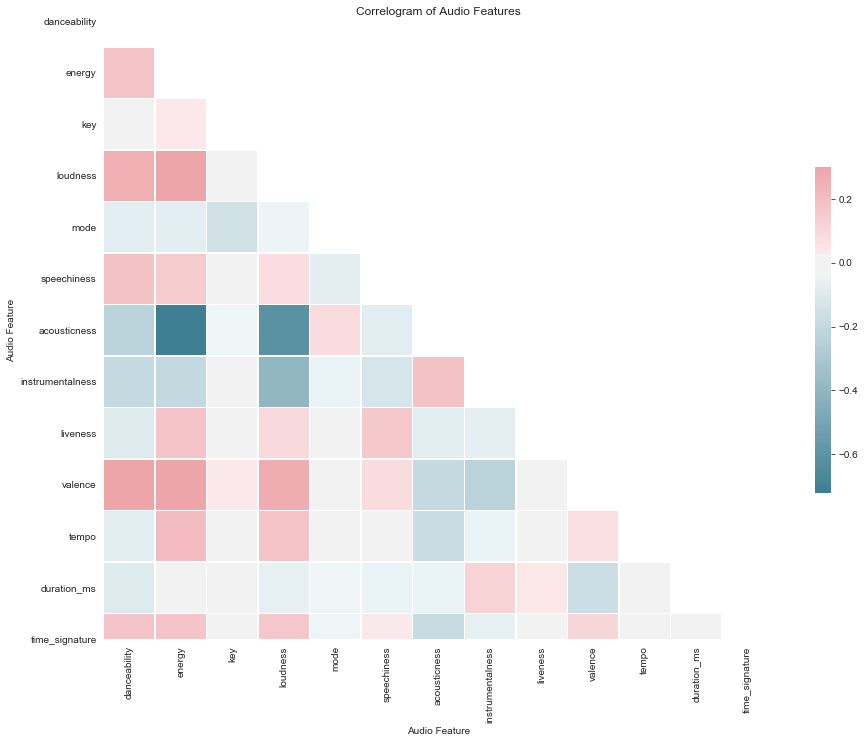

In [13]:
# Correlation matrix
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set_style("whitegrid", {'axes.grid' : False})

# Compute the correlation matrix
corr = playlist_numeric.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Set up labels
plt.xlabel("Audio Feature")
plt.ylabel("Audio Feature")
plt.title("Correlogram of Audio Features")
plt.savefig("../out/audio_features_correlogram.svg", quality=95, dpi=1200)
# plt.show()


Next, let's take a subset of the features and plot their pairwise distributions

/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


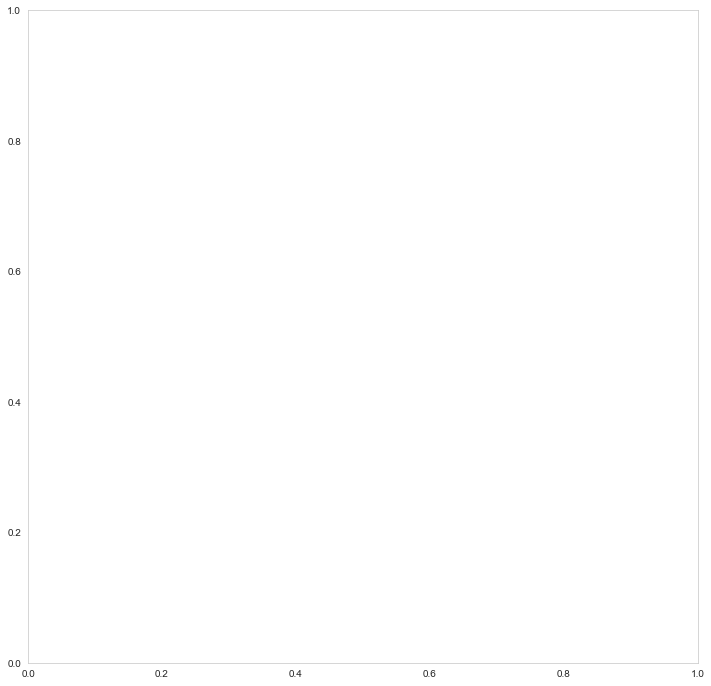

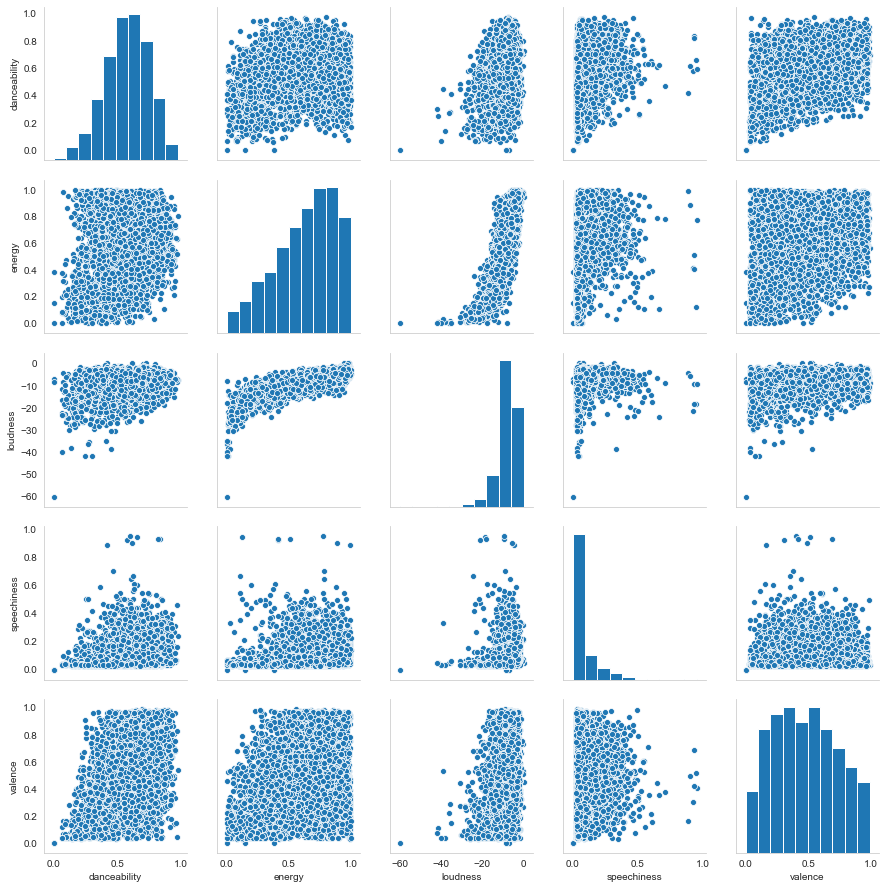

In [14]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Pairplot
pp = sns.pairplot(playlist_numeric.sample(frac=0.05)[["danceability", "energy", "loudness", "speechiness", "valence"]])

# # Set up labels
# plt.xlabel("Audio Feature")
# plt.ylabel("Audio Feature")
# plt.title("Pairwise Relationships Between Select Audio Features");

#### Playlist-level data

In [15]:
playlist_grouped_data.head()

NameError: name 'playlist_grouped_data' is not defined

As a simple analysis, let's see how many songs in each playlist:

In [ ]:
average_songs = np.mean(playlist_grouped_data.groupby("unique_pid").count()["pos"])
print(f"The average playlist has: {average_songs} songs")

With a distribution that looks like:

In [ ]:
grouped_by_pid = playlist_grouped_data.groupby("unique_pid").count()
plt.hist(grouped_by_pid["pos"])
plt.title("Number of Songs in Playlists")
plt.xlabel("Number of Songs")
plt.ylabel("Number of Playlists");

Now, before we run any further analysis, let's make our feature data the musical properties of songs in a playlist. We'll standardize our data across these features.

In [18]:
def normalize(df, scalar, features):
    # Split df into features and non-features
    non_feature_df = df[df.columns.difference(features)]
    feature_df = df[features]
    
    # Scale the features
    np_transform = scalar.transform(feature_df)
    df_transform = pd.DataFrame(np_transform, columns=features)

    # Merge back the features and non-features
    non_feature_df.reset_index(drop=True, inplace=True)
    df_transform.reset_index(drop=True, inplace=True)
    df_transform = pd.concat([non_feature_df, df_transform], axis = 1)
    
    return df_transform

In [19]:
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']

pids = playlist_grouped_data["unique_pid"]
playlist_data_ft = playlist_grouped_data[features]

scalar = MinMaxScaler().fit(playlist_data_ft)
playlists_transformed = scalar.transform(playlist_data_ft)
playlists_grouped_norm = pd.DataFrame(playlists_transformed, columns=features)
playlists_grouped_norm = pd.concat([pids, playlists_grouped_norm], axis = 1)

playlists_grouped_norm.head()

NameError: name 'playlist_grouped_data' is not defined

For starters, let's take at the average song features on a playlist level:

In [92]:
features_mean = {x: "mean" for x in features}

averaged_playlist_data = playlists_norm.groupby("unique_pid").agg(features_mean)
averaged_playlist_data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
unique_pid,,,,,,,,,,,,,
10,0.577079,0.68300,1.000000,0.886801,0.00,0.153527,0.199799,0.000000,0.10800,0.6340,0.643637,0.042287,0.8
11,0.592546,0.60925,0.590909,0.822062,0.75,0.071032,0.326305,0.626175,0.19725,0.3245,0.542421,0.057570,0.8
13,0.649087,0.75500,0.090909,0.889856,0.00,0.029772,0.013855,0.020800,0.12000,0.7440,0.481769,0.044771,0.8
14,0.621197,0.62200,0.636364,0.872114,1.00,0.032832,0.352209,0.457130,0.29710,0.4790,0.434849,0.047313,0.8
16,0.435598,0.89500,0.954545,0.892561,0.50,0.041961,0.015470,0.279435,0.34950,0.6885,0.538339,0.038013,0.8


## Baseline Model

#### K-means for labeling

The first thing we'll want to do is find similarities between "groups" of songs in our data set. To do so, we'll first need to construct groups, using their audio properties as features to group them by. Before we begin, we need to normalize our data.

In [20]:
# Fit MinMaxScalar and select features we will be using (all columns from playlist_numeric)
scalar = MinMaxScaler().fit(playlist_numeric)
features = playlist_numeric.columns

In [21]:
playlist_norm = normalize(playlist_numeric, scalar, features)
playlist_norm["trackid"] = playlist_numeric.index
playlist_norm = playlist_norm.set_index("trackid")

In [22]:
display(playlist_numeric.head())
display(playlist_norm.head())


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
trackid,,,,,,,,,,,,,
spotify:track:000xYdQfIZ4pDmBGzQalKU,0.509,0.803,0.0,-6.743,1.0,0.0400,0.6840,0.000539,0.4630,0.651,166.018,187119.0,4.0
spotify:track:0051XNkzp7FXjzG9dpijnN,0.573,0.446,7.0,-9.102,0.0,0.2210,0.0523,0.122000,0.1110,0.144,148.354,260187.0,4.0
spotify:track:00BHbc5GB5d35gsi8IsmZl,0.623,0.803,1.0,-5.523,0.0,0.0327,0.4380,0.000046,0.1650,0.645,126.610,231893.0,4.0
spotify:track:00BnfL75e8vHSGCmwUWbEk,0.597,0.468,8.0,-9.457,1.0,0.1170,0.0826,0.000007,0.0774,0.353,119.555,242347.0,4.0
spotify:track:00CrtqaRkCyFjY1yiSYJWo,0.610,0.683,1.0,-9.137,1.0,0.0376,0.1420,0.000004,0.1690,0.582,140.083,209053.0,4.0


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
trackid,,,,,,,,,,,,,
spotify:track:000xYdQfIZ4pDmBGzQalKU,0.515704,0.803,0.000000,0.864758,1.0,0.041494,0.686747,0.000539,0.4630,0.651,0.669266,0.039572,0.8
spotify:track:0051XNkzp7FXjzG9dpijnN,0.580547,0.446,0.636364,0.826454,0.0,0.229253,0.052510,0.122000,0.1110,0.144,0.598057,0.055192,0.8
spotify:track:00BHbc5GB5d35gsi8IsmZl,0.631206,0.803,0.090909,0.884568,0.0,0.033921,0.439759,0.000046,0.1650,0.645,0.510401,0.049143,0.8
spotify:track:00BnfL75e8vHSGCmwUWbEk,0.604863,0.468,0.727273,0.820690,1.0,0.121369,0.082932,0.000007,0.0774,0.353,0.481960,0.051378,0.8
spotify:track:00CrtqaRkCyFjY1yiSYJWo,0.618034,0.683,0.090909,0.825886,1.0,0.039004,0.142570,0.000004,0.1690,0.582,0.564714,0.044261,0.8


We have a couple NAs in our dataset, let's drop them

In [23]:
playlist_norm.isna().sum()

danceability        296
energy              296
key                 296
loudness            296
mode                296
speechiness         296
acousticness        296
instrumentalness    296
liveness            296
valence             296
tempo               296
duration_ms         296
time_signature      296
dtype: int64

In [24]:
playlist_norm = playlist_norm.dropna(how="all")

#### Compute heterogeneity and build "elbow" graph to optimze k
A typical approach to optimize the number of clusters, k, to segment data into is by using the "elbow chart" method. The goal of k-means is to minimize the sum of distances from the cluster centroids to each of their constituent points. The heterogeneity of each cluster represents how far these points are from their centroid. The elbow chart plots the heterogeneity against the number of k clusters. Ideally, we will choose a k that minimizes heterogeneity the most. Visually, this happens when the chart "elbows out"

Note: this k-means implementation was learned from University of Washington Coursera course in ML: https://www.coursera.org/specializations/machine-learning. As such, some of the code below will be similar to the k-means course assignments.

In [23]:
def compute_heterogeneity(num_clusters, df):
    '''Computes KMeans and saves score for each run'''
    kmeans = []
    score = []
    
    for i in num_clusters:
        print(f"""\n================================================"""
              f"""\nComputing KMeans for {i} cluster(s)"""
              f"""\n================================================""")
        
        kmeans.append(KMeans(n_clusters=i))
        score.append(kmeans[i - 1].fit(df).score(df))
        
        print(f"""Heterogeneity: {score[i-1]}""")
        
    return score

In [24]:
num_clusters = range(1,16)
score = compute_heterogeneity(num_clusters, playlist_norm)


Computing KMeans for 1 cluster(s)
Heterogeneity: -72558.01066783848

Computing KMeans for 2 cluster(s)
Heterogeneity: -49874.43274354577

Computing KMeans for 3 cluster(s)
Heterogeneity: -41416.48309758012

Computing KMeans for 4 cluster(s)
Heterogeneity: -37166.605602566306

Computing KMeans for 5 cluster(s)
Heterogeneity: -33762.421779030534

Computing KMeans for 6 cluster(s)
Heterogeneity: -31377.397338429215

Computing KMeans for 7 cluster(s)
Heterogeneity: -29303.570622543222

Computing KMeans for 8 cluster(s)
Heterogeneity: -27634.636135029352

Computing KMeans for 9 cluster(s)
Heterogeneity: -26308.156131097756

Computing KMeans for 10 cluster(s)
Heterogeneity: -25195.20846343152

Computing KMeans for 11 cluster(s)
Heterogeneity: -24135.745965561448

Computing KMeans for 12 cluster(s)
Heterogeneity: -23139.81223389443

Computing KMeans for 13 cluster(s)
Heterogeneity: -22512.203311928562

Computing KMeans for 14 cluster(s)
Heterogeneity: -21822.92331126126

Computing KMeans for

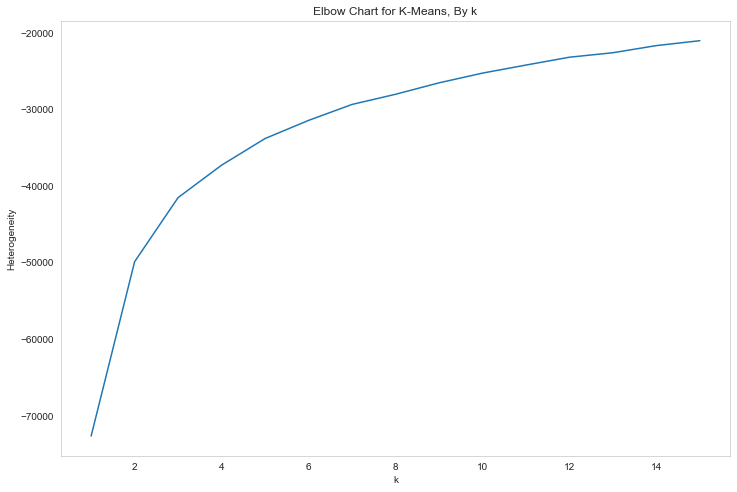

In [40]:
f, ax = plt.subplots(figsize=(12, 8))
ax.set_xlabel("k")
ax.set_ylabel("Heterogeneity")
plt.title("Elbow Chart for K-Means, By k")
plt.plot(num_clusters, score);

Thus, a good number of clusters could be 3, 5, 7, or 12, given the shape of the elbow chart above. We will choose 12 here because we want to differentiate our songs into as many groups as possible.

#### Run k-means with chosen number of clusters

The code below runs k-means clustering, assigns cluster labels, and outputs 1) our raw data with cluster assignments, and 2) mean data for each cluster

In [25]:
def kmeans(num_clusters, data):
    '''Runs kmeans algorithm, returning cluster assignment and centers'''
    # Initialize KMeans
    kmeans = KMeans(n_clusters=num_clusters)

    # Fitting with inputs
    kmeans = kmeans.fit(data)

    # Predicting clusters
    labels = kmeans.predict(data)

    # Get cluster centers
    centers = kmeans.cluster_centers_
    
    return labels, centers

In [26]:
def build_kmeans_output(data, col_name):
    '''Builds out final dataset'''
    df_means[col_name] = data.groupby(['cluster'])[col_name].mean().to_frame(col_name)    

In [27]:
def run_kmeans(df, clusters):
    # Run kmeans, given a specified number of clusters
    data = df.copy()
    labels, centers = kmeans(clusters, data.drop("trackid", axis=1))
    data['cluster'] = labels
    
    # Build df_means table to store results
    df_means = data.groupby(['cluster'])['trackid'].count().to_frame('n')
    
    for col in data.columns.values:
        if col != 'trackid':
            df_means[col] = data.groupby(['cluster'])[col].mean().to_frame(col)    
      
    # Generate alphabetical representation of clusters
    mapping = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6: 'G', 7:'H', 8:'I', 9:'J', 10:"K", 11:"L"}
    df_means['cluster_alpha'] = df_means['cluster']
    df_means = df_means.replace({'cluster_alpha':mapping})

    data['cluster_alpha'] = data['cluster']
    data = data.replace({'cluster_alpha':mapping})
    
    return df_means, data

In [28]:
k = 12
playlist_norm["trackid"] = playlist_norm.index
playlist_means, playlist_clusters = run_kmeans(playlist_norm, k)
playlist_means

,n,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster,cluster_alpha
cluster,,,,,,,,,,,,,,,,
0,10228,0.533810,0.708465,0.132728,0.870079,1.0,0.091803,0.089694,0.023448,0.225411,0.326582,0.508520,0.052380,0.788502,0,A
1,11461,0.677990,0.729062,0.711020,0.867131,1.0,0.100860,0.180648,0.016248,0.192319,0.745895,0.492028,0.046510,0.791170,1,B
2,13550,0.623623,0.717971,0.294364,0.869285,0.0,0.111476,0.148468,0.021222,0.212238,0.518825,0.493315,0.050568,0.792458,2,C
3,7651,0.527534,0.371488,0.729958,0.796971,1.0,0.075534,0.710501,0.023991,0.191307,0.394139,0.462923,0.048155,0.762593,3,D
4,9957,0.674209,0.733049,0.125914,0.867096,1.0,0.104755,0.172950,0.017551,0.200651,0.734224,0.495337,0.047018,0.793070,4,E
5,3503,0.591342,0.701366,0.567410,0.837695,0.0,0.068951,0.127328,0.758291,0.197035,0.401422,0.503152,0.059839,0.787554,5,F
6,3693,0.379044,0.214180,0.412623,0.677479,1.0,0.049603,0.868483,0.836893,0.142714,0.223244,0.434687,0.053107,0.749147,6,G
7,7438,0.504958,0.340663,0.176526,0.789596,1.0,0.068923,0.737441,0.023799,0.183627,0.347962,0.460625,0.049003,0.760419,7,H
8,11221,0.634328,0.718494,0.855814,0.867160,0.0,0.119985,0.145961,0.023888,0.209904,0.532613,0.492043,0.050560,0.793797,8,I


In [29]:
playlist_clusters.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,trackid,cluster,cluster_alpha
trackid,,,,,,,,,,,,,,,,
spotify:track:000xYdQfIZ4pDmBGzQalKU,0.515704,0.803,0.000000,0.864758,1.0,0.041494,0.686747,0.000539,0.4630,0.651,0.669266,0.039572,0.8,spotify:track:000xYdQfIZ4pDmBGzQalKU,4,E
spotify:track:0051XNkzp7FXjzG9dpijnN,0.580547,0.446,0.636364,0.826454,0.0,0.229253,0.052510,0.122000,0.1110,0.144,0.598057,0.055192,0.8,spotify:track:0051XNkzp7FXjzG9dpijnN,8,I
spotify:track:00BHbc5GB5d35gsi8IsmZl,0.631206,0.803,0.090909,0.884568,0.0,0.033921,0.439759,0.000046,0.1650,0.645,0.510401,0.049143,0.8,spotify:track:00BHbc5GB5d35gsi8IsmZl,2,C
spotify:track:00BnfL75e8vHSGCmwUWbEk,0.604863,0.468,0.727273,0.820690,1.0,0.121369,0.082932,0.000007,0.0774,0.353,0.481960,0.051378,0.8,spotify:track:00BnfL75e8vHSGCmwUWbEk,11,L
spotify:track:00CrtqaRkCyFjY1yiSYJWo,0.618034,0.683,0.090909,0.825886,1.0,0.039004,0.142570,0.000004,0.1690,0.582,0.564714,0.044261,0.8,spotify:track:00CrtqaRkCyFjY1yiSYJWo,4,E


#### Visualize attributes across clusters

In [42]:
def plot_bar_by_cluster(df, cols):
    sns.set(style="whitegrid")

    # Draw a nested barplot 
    chart = sns.catplot(x=cols[0], y=cols[1], data=df[cols],
                    height=6, kind="bar", palette="Blues_r")
    chart.despine(left=True)
    chart.set_ylabels(cols[1])
    chart.set_xlabels(cols[0])
    if cols[1] == "n":
        plt.title(f"""{cols[1]} by cluster""", pad=0); 
    else:
        plt.title(f"""Mean {cols[1]} by cluster""", pad=0); 
        
    plt.savefig(f"../out/{cols[1]}_cluster_comparison.svg", dpi=1200)

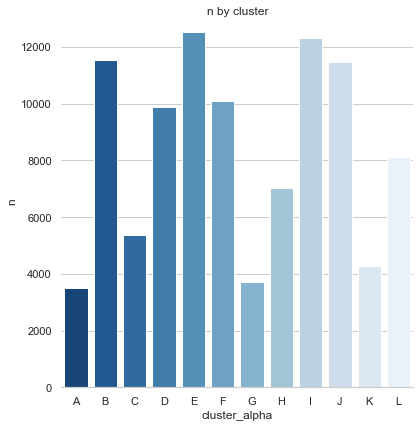

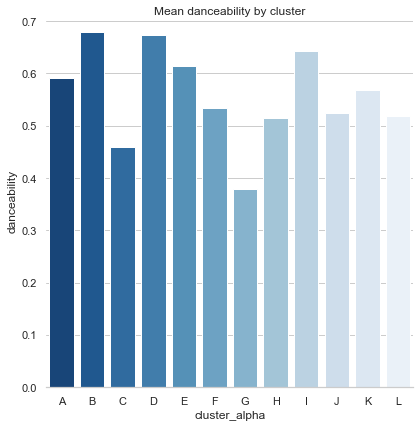

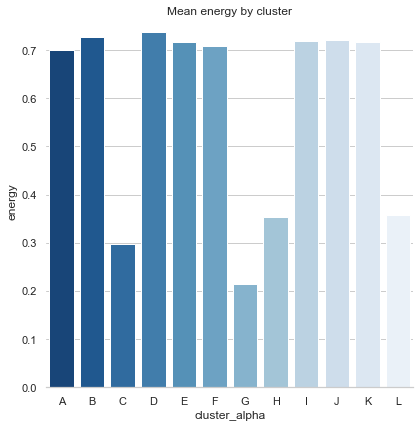

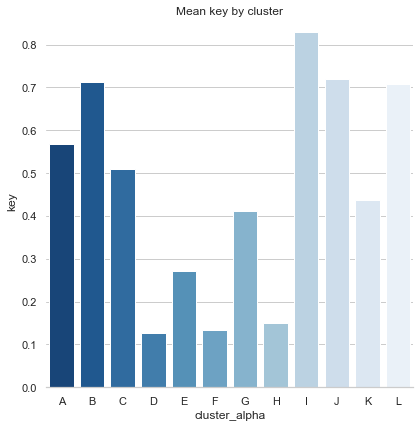

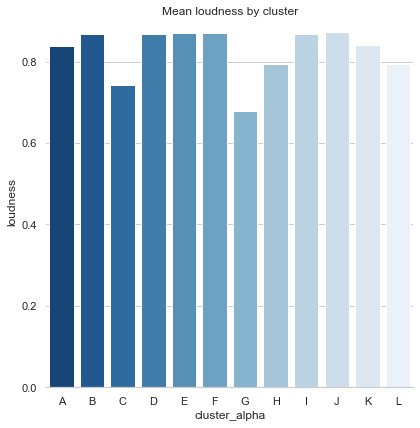

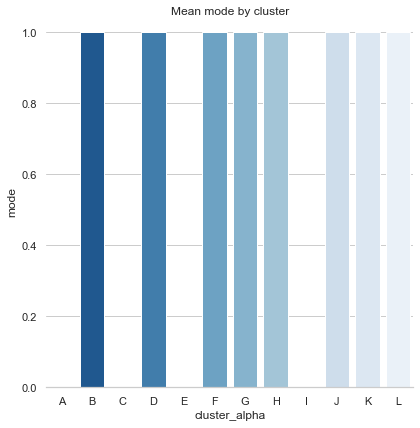

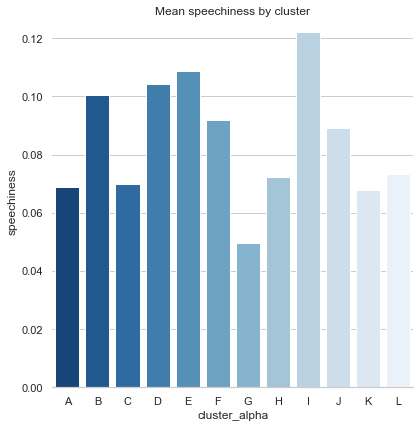

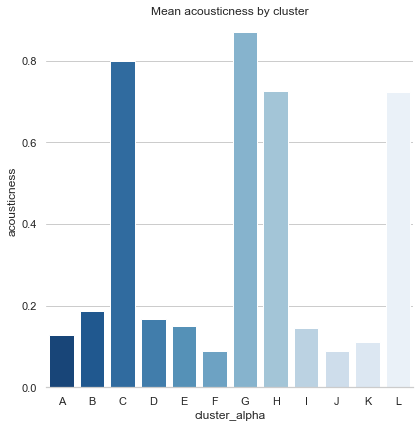

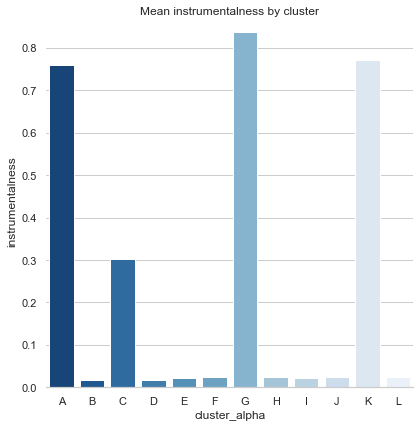

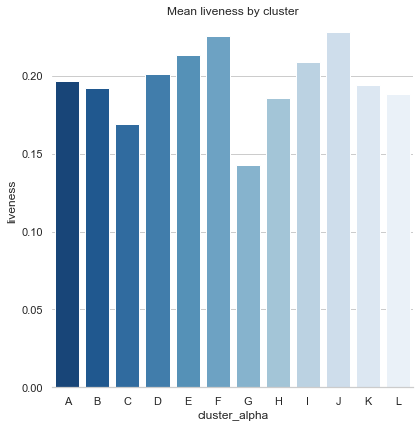

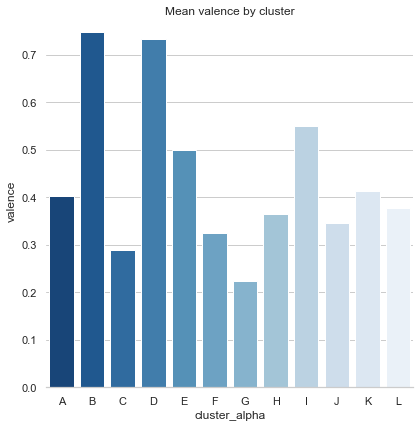

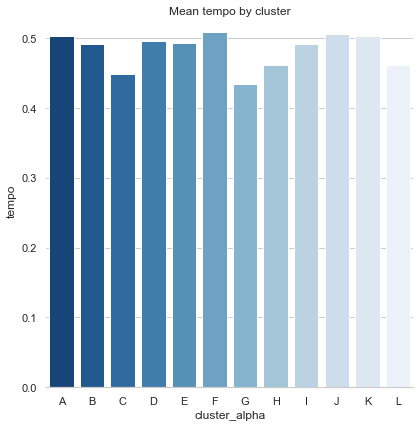

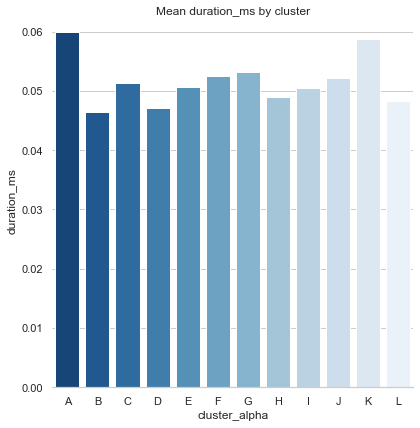

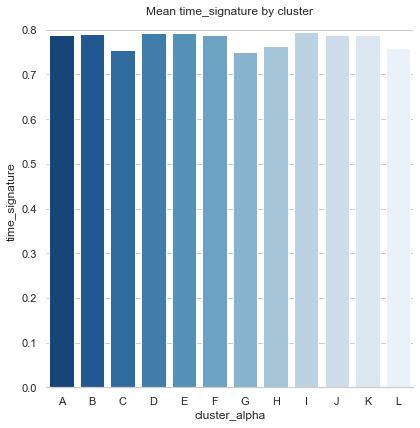

In [43]:
features = ['n','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
           'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
           'duration_ms', 'time_signature']

for feature in features:
    cols = ["cluster_alpha"]
    cols.append(feature)
    plot_bar_by_cluster(playlist_means, cols)

#### K-Nearest Neighbors

Great, now that we have labels for our tracks (cluster number), we can build a recommender engine. Let's use K-Nearest neighbors to fit future songs to a given cluster. First, we need to split our data into train and test.

In [30]:
playlist_clusters = playlist_clusters.drop(["trackid", "cluster_alpha"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(playlist_clusters.loc[:, playlist_clusters.columns != 'cluster'], 
                                                    playlist_clusters.cluster, test_size=0.2, 
                                                    random_state = 666, 
                                                    stratify = playlist_clusters.cluster)

In [31]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((79763, 13), (19941, 13), (79763,), (19941,))

Now, we will optimize the number of k nearest-neighbors by using cross-validation to select the best. Given the fact that each of our clusters is quite large (mean of `8313`), we'll test relatively large values of k

In [32]:
# Mean observations in each cluster
playlist_means["n"].mean()

8308.666666666666

In [70]:
# ks = [2, 5, 7, 10, 20, 25, 50, 100]
# https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a
ks = [1, 5, 100, 250, 500, 1000, 2500, 5000, 10000]
output = []

for k in ks:
    print(f'''**************************************'''
          f'''\nRunning kNN classification for k={k}''')
    knn_cv = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn_cv, X_train, y_train, cv=5)
    output.append({"k": k, "cv_scores_mean": np.mean(cv_scores)})
    print(f'''cv_scores: {cv_scores}''')
    print(f'''cv_scores mean: {np.mean(cv_scores)}''')


**************************************
Running kNN classification for k=1
cv_scores: [0.93178829 0.93447347 0.93052249 0.93057644 0.93136948]
cv_scores mean: 0.9317460330896911
**************************************
Running kNN classification for k=5
cv_scores: [0.95258378 0.95408131 0.95257487 0.95394737 0.95067377]
cv_scores mean: 0.9527722187505653
**************************************
Running kNN classification for k=100
cv_scores: [0.97932978 0.97826223 0.97707054 0.97775689 0.97931683]
cv_scores mean: 0.9783472557323819
**************************************
Running kNN classification for k=250
cv_scores: [0.97763858 0.97794901 0.97775968 0.97869674 0.97906612]
cv_scores mean: 0.978222027209469
**************************************
Running kNN classification for k=500
cv_scores: [0.97694958 0.97563115 0.97625611 0.97681704 0.97756189]
cv_scores mean: 0.9766431535829639
**************************************
Running kNN classification for k=1000
cv_scores: [0.97381773 0.97293742

In [72]:
pd.DataFrame(output)

,k,cv_scores_mean
0,1,0.931746
1,5,0.952772
2,100,0.978347
3,250,0.978222
4,500,0.976643
5,1000,0.973097
6,2500,0.954715
7,5000,0.900745
8,10000,0.807318


In [33]:
neighbors = 100
knn_chosen = KNeighborsClassifier(n_neighbors=neighbors).fit(X_train, y_train)
knn_chosen_predictions_train = knn_chosen.predict(X_train)
knn_chosen_predictions_test = knn_chosen.predict(X_test)

In [34]:
def report_accuracy_and_misclassification(y_train, y_test, predictions_train, predictions_test):
    print(f'''Accuracy score on training data: '''
          f'''\t\t{accuracy_score(y_train, predictions_train)}''')

    print(f'''Misclassification rate on training data: '''
          f'''\t{1 - accuracy_score(y_train, predictions_train)}''')

    print(f'''Accuracy score on test data: '''
          f'''\t\t\t{accuracy_score(y_test, predictions_test)}''')

    print(f'''Misclassification rate on test data: '''
          f'''\t\t{1 - accuracy_score(y_test, predictions_test)}''')
            

In [35]:
report_accuracy_and_misclassification(y_train, 
                                      y_test, 
                                      knn_chosen_predictions_train, 
                                      knn_chosen_predictions_test)

Accuracy score on training data: 		0.9786868598222234
Misclassification rate on training data: 	0.021313140177776635
Accuracy score on test data: 			0.9766310616318139
Misclassification rate on test data: 		0.0233689383681861


#### Make Predictions With K-Nearest Neighbors
Now that we have a model, selected using cross-validation, we can predict class labels. Can we also get the most similar song? The below returns a list of the *n* closest songs in terms of feature vector distance

The first song in our X_test data is Dean Martin's "A Marshmallow World". Let's classify it into its appropriate cluster.

In [73]:
X_test.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
trackid,,,,,,,,,,,,,
spotify:track:2Vh83LPCK3rzO8shVIfRD4,0.796353,0.446,0.818182,0.804030,0.0,0.036100,0.310241,0.127000,0.2760,0.881,0.443578,0.044660,0.8
spotify:track:4lOsem5dgUzT6NemC0dIWF,0.527862,0.604,0.818182,0.861754,1.0,0.026763,0.202811,0.000397,0.2730,0.185,0.370011,0.044962,0.8
spotify:track:2VUVMZhSNWLp9y1XMB2tsF,0.510638,0.756,0.363636,0.827867,0.0,0.038382,0.551205,0.177000,0.0925,0.491,0.322511,0.037289,0.8
spotify:track:31pq1fkd9oIRFG1UkZXfYL,0.361702,0.812,0.818182,0.877423,1.0,0.058817,0.036345,0.000000,0.1670,0.810,0.570805,0.039316,0.8
spotify:track:0yPkjZSeGf9rOgH4gAHHIZ,0.646403,0.427,0.909091,0.805410,1.0,0.062552,0.649598,0.000009,0.0925,0.964,0.402826,0.035494,0.6


In [141]:
def generate_nearest_songs(trackid, features):
    mapping = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6: 'G', 7:'H', 8:'I', 9:'J', 10: 'K', 11: 'L'}
    feature_vector = features.loc[trackid].drop("cluster").to_numpy().reshape(1,-1)
    predicted_cluster = mapping[knn_chosen.predict(feature_vector)[0]]
    
    # These are the indices of the 100 closest neighbors to our song of interest
    kneighbors = knn_chosen.kneighbors(feature_vector)
    kneighbors_indices = kneighbors[1].reshape(-1)
    kneighbors_distances = kneighbors[0].reshape(-1)
    
    
    df = pd.DataFrame({"index": kneighbors_indices, "distance": kneighbors_distances})
    df.set_index("index")
#     print(df)
    
    # Let's get the track info for these 100
#     print(playlist_data.iloc[kneighbors_indices][["trackid", "artist_name", "track_name"]])
#     kneighbors_tracks = playlist_data[playlist_data["trackid"].isin(features.iloc[kneighbors_indices].index)]\
#         [["trackid", "artist_name", "track_name"]]
    kneighbors_tracks = playlist_data.iloc[kneighbors_indices][["trackid", "artist_name", "track_name"]]
    kneighbors_tracks["distance"] = kneighbors_distances
    
    # K-neighbors graph
    kneighbors_graph = knn_chosen.kneighbors_graph(feature_vector)
    
    return predicted_cluster, kneighbors_tracks, kneighbors_graph

In [184]:
def plot_nearest_neighbors(neighbors_df, artist_track):
    plot_df = neighbors_df[["artist_track", "distance"]]

    fig, ax = plt.subplots()
    ax = sns.barplot(x='distance', y='artist_track', data=plot_df, palette="Blues_d")
    ax.set_xlabel('distance')
    plt.title(artist_track)
    
    filename = artist_track.replace(" ", "").replace(":", "_")
    plt.tight_layout()
    plt.savefig(f"../out/{filename}_nearestneighbors.svg", quality=95, dpi=1200)
    

,artist_track,cluster
0,Kendrick Lamar: m.A.A.d city,A
1,Dean Martin: Marshmallow World,D
2,Slayer: Raining Blood,C


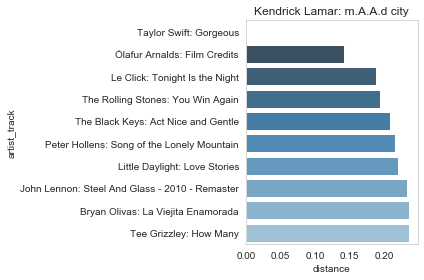

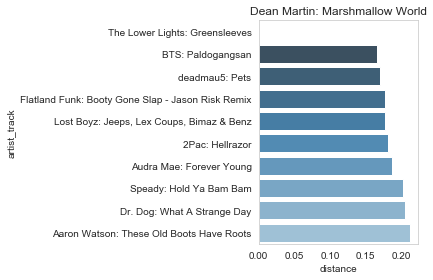

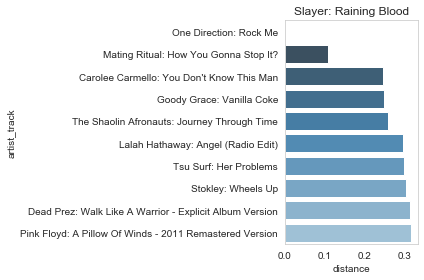

In [192]:
# Kendrick Lamar, m.A.A.d city: "spotify:track:439TlnnznSiBbQbgXiBqAd"
# Dean Martin, A Marshmallow World: "spotify:track:3szI9hDVbyOYU0yd77G35n"
# Slayer, Raining Blood: "spotify:track:4Yx9Tw9dTgQ8eGCq3PRDyn"
clusters = []

# Kendrick Lamar, m.A.A.d city: "spotify:track:439TlnnznSiBbQbgXiBqAd"
cluster, neighbors, graph = generate_nearest_songs("spotify:track:439TlnnznSiBbQbgXiBqAd", playlist_clusters)
artist_track = "Kendrick Lamar: m.A.A.d city"
neighbors["artist_track"] = neighbors["artist_name"] + ": " + neighbors["track_name"]
clusters.append({"artist_track": artist_track, "cluster": cluster})
plot_nearest_neighbors(neighbors.head(10), artist_track)

# Dean Martin, A Marshmallow World: "spotify:track:3szI9hDVbyOYU0yd77G35n"
cluster, neighbors, graph = generate_nearest_songs("spotify:track:3szI9hDVbyOYU0yd77G35n", playlist_clusters)
artist_track = "Dean Martin: Marshmallow World"
neighbors["artist_track"] = neighbors["artist_name"] + ": " + neighbors["track_name"]
clusters.append({"artist_track": artist_track, "cluster": cluster})
plot_nearest_neighbors(neighbors.head(10), artist_track)
# print(f"Cluster assignment for {artist_track}: {cluster}")

# Slayer, Raining Blood: "spotify:track:4Yx9Tw9dTgQ8eGCq3PRDyn"
cluster, neighbors, graph = generate_nearest_songs("spotify:track:4Yx9Tw9dTgQ8eGCq3PRDyn", playlist_clusters)
artist_track = "Slayer: Raining Blood"
neighbors["artist_track"] = neighbors["artist_name"] + ": " + neighbors["track_name"]
clusters.append({"artist_track": artist_track, "cluster": cluster})
plot_nearest_neighbors(neighbors.head(10), artist_track)
# print(f"Cluster assignment for {artist_track}: {cluster}")

pd.DataFrame(clusters)

In [50]:
playlist_clusters.loc["spotify:track:439TlnnznSiBbQbgXiBqAd"]

danceability        0.493414
energy              0.729000
key                 0.181818
loudness            0.863589
mode                1.000000
speechiness         0.281120
acousticness        0.054016
instrumentalness    0.000004
liveness            0.440000
valence             0.217000
tempo               0.367040
duration_ms         0.074416
time_signature      0.800000
cluster             0.000000
Name: spotify:track:439TlnnznSiBbQbgXiBqAd, dtype: float64

In [155]:
data = playlist_clusters.loc["spotify:track:3szI9hDVbyOYU0yd77G35n"].drop("cluster").to_numpy().reshape(1,-1)
prediction = knn_chosen.predict(data)[0]
print(mapping[prediction])

kneighbors_indices = knn_chosen.kneighbors(data)[1].reshape(-1)
playlist_data.iloc[kneighbors_indices][["trackid", "artist_name", "track_name"]]

D


,trackid,artist_name,track_name
35760,spotify:track:3g3tJgIY9saUzC5WmF4t9h,The Lower Lights,Greensleeves
47123,spotify:track:1yFEQO3mOtDAje6rOyj2Cf,BTS,Paldogangsan
13281,spotify:track:78hbC4snQ79I7UcmGi4xxw,deadmau5,Pets
54002,spotify:track:5fflVQkg4yQ91j4x2Ddx6j,Flatland Funk,Booty Gone Slap - Jason Risk Remix
14562,spotify:track:02nH7HXbs3i9kdWef9or8E,Lost Boyz,"Jeeps, Lex Coups, Bimaz & Benz"
...,...,...,...
4110,spotify:track:29tzJGvqJPTAFs6LXmsHoA,Arctic Monkeys,R U Mine?
55560,spotify:track:6VOBt72j0S7CNq5Z85nc8C,The Call,The Walls Came Down - Single Version
21288,spotify:track:3Zq3hTVRPNvAIK5Ej8MqOO,Cold War Kids,We Used To Vacation
14299,spotify:track:7uXH0Q1uYdwDt1lVDRMfho,Cocainejesus,You Don't Forget Girls With Grey Eyes


In [138]:
mapping = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6: 'G', 7:'H', 8:'I', 9:'J', 10: 'K', 11: 'L'}
test_index = 2
playlist_data.iloc[playlist_data.index[playlist_data["trackid"] == X_test.index[test_index]]]

,unique_pid,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,album_name,index,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,trackid,random,track_row
76891,97750,50,5,Local Natives,spotify:track:2VUVMZhSNWLp9y1XMB2tsF,spotify:artist:75dQReiBOHN37fQgWQrIAJ,Ceilings,spotify:album:1vONbFftSl3PkZs5ayRJ4B,Hummingbird,84.0,...,audio_features,2VUVMZhSNWLp9y1XMB2tsF,spotify:track:2VUVMZhSNWLp9y1XMB2tsF,https://api.spotify.com/v1/tracks/2VUVMZhSNWLp...,https://api.spotify.com/v1/audio-analysis/2VUV...,176440.0,4.0,spotify:track:2VUVMZhSNWLp9y1XMB2tsF,0.005103,1


Our model predicts this song will be in Cluster I

In [182]:
prediction = knn_chosen.predict(X_test.iloc[test_index].to_numpy().reshape(1,-1))[0]
print(f"The predicted cluster for this song is {mapping[prediction]}")

The predicted cluster for this song is I


Next, let's get a list of the 100 most similar songs. As you can see below we have similar artists to Dean Martin, such as John Denver, George Jones, and Dean Martin himself. Cool!

In [184]:
# These are the indices of the 100 closest neighbors to our song of interest
kneighbors_indices = knn_chosen.kneighbors(X_test.iloc[test_index].to_numpy().reshape(1,-1))[1].reshape(-1)

# Let's get the track info for these 100
playlist_data[playlist_data["trackid"].isin(X_train.ix[kneighbors_indices].index)]\
    [["trackid", "artist_name", "track_name"]]

/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """


,trackid,artist_name,track_name
134,spotify:track:04b8oP2TafbCEJdaaCEnEX,Voz Veis,Aunque Sea Poco (Versión Acústica)
1655,spotify:track:0s874oaYUddJGeKmGlX9o4,Selena,Como Te Quiero Yo A Ti
2357,spotify:track:1Db3RDS6mdsuD5ibO7Bo1F,Whitley,More Than Life
2674,spotify:track:1ORONFOMyCcwFVvfHMH2Ky,The Delfonics,I'm Sorry - Remastered
2988,spotify:track:1YYhDizHx7PnDhAhko6cDS,John Denver,"Take Me Home, Country Roads - Original Version..."
...,...,...,...
90222,spotify:track:1tHEwrjI0yikpUk0CRNw8N,George Jones,"Swing Low, Sweet Chariot"
91577,spotify:track:2dqRgUIrAX6Ptads6ttPDw,Dan Auerbach,Whispered Words (Pretty Lies)
92729,spotify:track:3G3sjrRx3BwAkuqYbLDHEk,Dean Martin,Buona Sera - 1998 Digital Remaster
94000,spotify:track:3vsleqgIlGso3digeTpx6H,Gardiner Sisters,Like I Can


In [172]:
playlist_data[playlist_data["artist_name"] == "Kendrick Lamar"]

,unique_pid,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,album_name,index,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,trackid,random,track_row
2781,151602,602,88,Kendrick Lamar,spotify:track:1S6NpdvFXqHZfPUUEOIjtG,spotify:artist:2YZyLoL8N0Wb9xBt1NhZWg,Opposites Attract (Tomorrow W/O Her),spotify:album:7MoLQ8vckhwBbQqEYQTYQC,Overly Dedicated,96.0,...,audio_features,1S6NpdvFXqHZfPUUEOIjtG,spotify:track:1S6NpdvFXqHZfPUUEOIjtG,https://api.spotify.com/v1/tracks/1S6NpdvFXqHZ...,https://api.spotify.com/v1/audio-analysis/1S6N...,271909.0,4.0,spotify:track:1S6NpdvFXqHZfPUUEOIjtG,0.001179,1
5059,11244,244,49,Kendrick Lamar,spotify:track:2fgAJeky8Cpsr8Cfvn2NVp,spotify:artist:2YZyLoL8N0Wb9xBt1NhZWg,untitled 03 | 05.28.2013.,spotify:album:0kL3TYRsSXnu0iJvFO3rud,untitled unmastered.,98.0,...,audio_features,2fgAJeky8Cpsr8Cfvn2NVp,spotify:track:2fgAJeky8Cpsr8Cfvn2NVp,https://api.spotify.com/v1/tracks/2fgAJeky8Cps...,https://api.spotify.com/v1/audio-analysis/2fgA...,154347.0,4.0,spotify:track:2fgAJeky8Cpsr8Cfvn2NVp,0.006285,1
7214,63892,92,120,Kendrick Lamar,spotify:track:3q2v8QaTnHLveAQzR6gvYm,spotify:artist:2YZyLoL8N0Wb9xBt1NhZWg,"Sing About Me, I'm Dying Of Thirst",spotify:album:3DGQ1iZ9XKUQxAUWjfC34w,"good kid, m.A.A.d city",35.0,...,audio_features,3q2v8QaTnHLveAQzR6gvYm,spotify:track:3q2v8QaTnHLveAQzR6gvYm,https://api.spotify.com/v1/tracks/3q2v8QaTnHLv...,https://api.spotify.com/v1/audio-analysis/3q2v...,723573.0,5.0,spotify:track:3q2v8QaTnHLveAQzR6gvYm,0.005049,1
7614,4876,76,48,Kendrick Lamar,spotify:track:439TlnnznSiBbQbgXiBqAd,spotify:artist:2YZyLoL8N0Wb9xBt1NhZWg,m.A.A.d city,spotify:album:6PBZN8cbwkqm1ERj2BGXJ1,"good kid, m.A.A.d city",81.0,...,audio_features,439TlnnznSiBbQbgXiBqAd,spotify:track:439TlnnznSiBbQbgXiBqAd,https://api.spotify.com/v1/tracks/439TlnnznSiB...,https://api.spotify.com/v1/audio-analysis/439T...,350120.0,4.0,spotify:track:439TlnnznSiBbQbgXiBqAd,0.003761,1
7861,244,4,111,Kendrick Lamar,spotify:track:4BHSjbYylfOH5WAGusDyni,spotify:artist:2YZyLoL8N0Wb9xBt1NhZWg,YAH.,spotify:album:4eLPsYPBmXABThSJ821sqY,DAMN.,14.0,...,audio_features,4BHSjbYylfOH5WAGusDyni,spotify:track:4BHSjbYylfOH5WAGusDyni,https://api.spotify.com/v1/tracks/4BHSjbYylfOH...,https://api.spotify.com/v1/audio-analysis/4BHS...,160293.0,4.0,spotify:track:4BHSjbYylfOH5WAGusDyni,0.000926,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88209,2033,33,95,Kendrick Lamar,spotify:track:0qGFnxDIqGBIq2D3zNbjk9,spotify:artist:2YZyLoL8N0Wb9xBt1NhZWg,Sherane a.k.a Master Splinter’s Daughter,spotify:album:3DGQ1iZ9XKUQxAUWjfC34w,"good kid, m.A.A.d city",4.0,...,audio_features,0qGFnxDIqGBIq2D3zNbjk9,spotify:track:0qGFnxDIqGBIq2D3zNbjk9,https://api.spotify.com/v1/tracks/0qGFnxDIqGBI...,https://api.spotify.com/v1/audio-analysis/0qGF...,273640.0,4.0,spotify:track:0qGFnxDIqGBIq2D3zNbjk9,0.003142,1
88965,9858,58,121,Kendrick Lamar,spotify:track:1EaKU4dMbesXXd3BrLCtYG,spotify:artist:2YZyLoL8N0Wb9xBt1NhZWg,ELEMENT.,spotify:album:4eLPsYPBmXABThSJ821sqY,DAMN.,44.0,...,audio_features,1EaKU4dMbesXXd3BrLCtYG,spotify:track:1EaKU4dMbesXXd3BrLCtYG,https://api.spotify.com/v1/tracks/1EaKU4dMbesX...,https://api.spotify.com/v1/audio-analysis/1EaK...,208733.0,4.0,spotify:track:1EaKU4dMbesXXd3BrLCtYG,0.006971,1
91290,37143,143,102,Kendrick Lamar,spotify:track:2UOYzhusMTypF7oAQwksCj,spotify:artist:2YZyLoL8N0Wb9xBt1NhZWg,Hood Politics,spotify:album:7ycBtnsMtyVbbwTfJwRjSP,To Pimp A Butterfly,29.0,...,audio_features,2UOYzhusMTypF7oAQwksCj,spotify:track:2UOYzhusMTypF7oAQwksCj,https://api.spotify.com/v1/tracks/2UOYzhusMTyp...,https://api.spotify.com/v1/audio-analysis/2UOY...,292520.0,4.0,spotify:track:2UOYzhusMTypF7oAQwksCj,0.001944,1
94765,9870,0,2,Kendrick Lamar,spotify:track:4M2t7bP4Mq87mGMn0PObUX,spotify:artist:2YZyLoL8N0Wb9xBt1NhZWg,untitled 06 | 06.30.2014.,spotify:album:0kL3TYRsSXnu0iJvFO3rud,untitled unmastered.,78.0,...,audio_features,4M2t7bP4Mq87mGMn0PObUX,spotify:track:4M2t7bP4Mq87mGMn0PObUX,https://api.s